In [1]:
library(conflicted)
library(readxl)
library(gtools)
library(plm)
library(tidyverse)
library(modelsummary)
library(huxtable)
library(dplyr)
library(writexl)
library(sjPlot)
library(DescTools)
library(caTools)
library(psych)
library(pcse)
library(stringr)
conflict_prefer("lag", "stats")
conflict_prefer("Mean", "modelsummary")
conflict_prefer("N", "modelsummary")
conflict_prefer("SD", "modelsummary")
conflicted::conflicts_prefer(plm::lag)

# Override default glance.pgmm for summary control
glance.pgmm <- function(x, robust = FALSE, ...) {
  asummary <- summary(x, robust = robust)
  pdim <- attr(asummary, "pdim")
  data.frame(
    N      = pdim$nT$n * (pdim$nT$T - 1),
    Sargan = asummary$sargan$p.value[["chisq"]],
    AR1    = asummary$m1$p.value[1],
    AR2    = asummary$m2$p.value[1]
  )
}
Path.HOME <- path.expand("~")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
[conflicted] Will prefer stats::lag over any other package.
[conflicted] Will prefer modelsummary::Mean over any other package.
[conflicted] Will prefer modelsummary::N over any other package.
[conflicted] Will prefer modelsummary::SD over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer plm::lag over any other package.


In [2]:
gm <- tibble::tribble(
  ~raw, ~clean, ~fmt,
  "N", "N", "%d",
  "Sargan", "Sargan", "%.2f",
  "AR1", "AR(1)", "%.2f",
  "AR2", "AR(2)", "%.2f",
  "nobs", "N", "%d",
  "r.squared","R2","%.2f",
  # "time_effect", "时间效应", "%s",
  # "individual_effect", "个体效应", "%s",
  "utest_top", "拐点", "%s",
  "utest_x_max", "上限", "%.2f",
  "utest_x_min", "下限", "%.2f"
)

SIG <- c("*" = .1, "**" = .05, "***" = .01)

names <- c(
    "SDI" = "SDI",
    "SDI_Average" = "SDI_Average",
    "SDI_Equal" = "SDI_Equal",
    
    "lnFDIstock" = "lnFDIstock",
    "lnFDIstock_winsor" = "lnFDIstock_winsor",
    "I(lnFDIstock^2)" = "lnFDIstock2",
    "I(lnFDIstock_winsor^2)" = "lnFDIstock_winsor2",

    "lngreenfdistock" = "lngreenfdi",
    "I(lngreenfdistock^2)" = "lngreenfdi2",

    "lnmafdistock" = "lnmergerfdi",
    "I(lnmafdistock^2)" = "lnmergerfdi2",

    "lnFDI_CN" = "lnFDIstock",
    "lnFDI_US" = "lnFDIstock",
    "lnFDI_NL" = "lnFDIstock",
    "lnFDI_FR" = "lnFDIstock",

    "I(lnFDI_CN^2)" = "lnFDIstock2",
    "I(lnFDI_US^2)" = "lnFDIstock2",
    "I(lnFDI_NL^2)" = "lnFDIstock2",
    "I(lnFDI_FR^2)" = "lnFDIstock2",
    
    "economic" = "economic",
    "WGI" = "WGI",
    "natural" = "natural",
    "urban" = "urban",   
    "military" = "military"

)

utest <- function(model, var1, var2, fieller = FALSE) {
  dof <- df.residual(model)
  beta <- coef(model)
  covar <- vcov(model)
  b1 <- beta[var1]
  b2 <- beta[var2]
  s11 <- covar[var1, var1]
  s22 <- covar[var2, var2]
  s12 <- covar[var1, var2]
  x_min <- min(model$model[var1])
  x_max <- max(model$model[var1])
  xsq<- model$model[var1]**2
  mode <- "quad"
  t_min <- (b1 + 2 * (b2) * (x_min)) / sqrt(s11 + 4 * (x_min)^2 * s22 + 4 * (x_min) * s12)
  sl_min <- (b1 + 2 * (b2) * (x_min))
  t_max <- (b1 + 2 * (b2) * (x_max)) / sqrt(s11 + 4 * (x_max)^2 * s22 + 4 * (x_max) * s12)
  sl_max <- (b1 + 2 * (b2) * (x_max))
  top <- -(b1) / (2 * b2)
  t_sac <- min(abs(t_min), abs(t_max))
  if (t_min * t_max > 0) {
    t <- NA
    p <- NA
  } else {
    t <- t_sac
    p <- 2 * pt(t_sac, dof, lower.tail = TRUE)
  }
  stars <- ifelse(p < 0.001, "***", ifelse(p < 0.01, "**", ifelse(p <
    0.05, "*", "")))
  breakpoint <- top
  ret <- list(
    statistics = t,
    p.value = p,
    top = top,
    x_min = x_min,
    x_max = x_max
  )
  ret
}
glance_custom.plm <- function(model, ...) {
  ret <- data.frame(
    time_effect = ifelse(
      model$call$effect == "time" | model$call$effect == "twoways",
      "是",
      "否"
    ),
    twoways_effect = ifelse(
      model$call$effect == "twoways",
      "是",
      "否"
    )
  )
  Xs <- (model %>% formula() %>% as.character())[[3]]
  if (str_detect(Xs, "I\\(.+\\^2\\)")) {
    reg.variables <- (formula(model) %>% as.character())[[3]] %>% str_split("\\s*\\+\\s*")
    utest_res <- utest(model, reg.variables[[1]][1], reg.variables[[1]][2])
    stars <- ifelse(utest_res$p.value < 0.001, "***", ifelse(utest_res$p.value <
      0.01, "**", ifelse(utest_res$p.value < 0.05, "*", "")))
    stars <- ifelse(is.na(utest_res$p.value), "", stars)
    ret[["utest_top"]] <- utest_res$top %>%
      round(2) %>%
      as.character() %>%
      paste0(stars)
    ret[["utest_x_min"]] <- utest_res$x_min %>%
      round(2)
    ret[["utest_x_max"]] <- utest_res$x_max %>%
      round(2)
  }
  ret
}

glance_custom.lm <- function(model, ...) {
  ret <- data.frame(dummy = NA)
  Xs <- (model %>% formula() %>% as.character())[[3]]
  if (str_detect(Xs, "I\\(.+\\^2\\)")) {
    reg.variables <- (formula(model) %>% as.character())[[3]] %>% str_split("\\s*\\+\\s*")
    utest_res <- utest(model, reg.variables[[1]][1], reg.variables[[1]][2])
    stars <- ifelse(utest_res$p.value < 0.001, "***", ifelse(utest_res$p.value <
      0.01, "**", ifelse(utest_res$p.value < 0.05, "*", "")))
    stars <- ifelse(is.na(utest_res$p.value), "", stars)
    ret[["utest_top"]] <- utest_res$top %>% round(4) %>% as.character() %>% paste0(stars)
    ret[["utest_x_min"]] <- utest_res$x_min
    ret[["utest_x_max"]] <- utest_res$x_max
  }
  ret
}

library(ggplot2)
library(ggeffects)
flatui <- c("#DF7A5E", "#F0C986", "#82B29A", "#3C405B")

In [3]:
df <- pdata.frame(read.csv(file.path(path.expand("~"), "OneDrive/PhD Dissertation/Data_Code/Data/fdidata.csv")),
    index = c("Numeric", "Year")
)

df["SDI_100"] <- df["SDI"] * 100
df["SDI_Average_100"] <- df["SDI_Average"] * 100
df["SDI_Equal_100"] <- df["SDI_Equal"] * 100
df["SDI_Economy_100"] <- df["SDI_Economy"] * 100
df["SDI_Society_100"] <- df["SDI_Society"] * 100
df["SDI_Resource_100"] <- df["SDI_Resource"] * 100
df["SDI_Ecology_100"] <- df["SDI_Ecology"] * 100


# df["SDI_Average"] <- df["SDI_Average"] * 100
# df["SDI_Equal"] <- df["SDI_Equal"] * 100



# df_sum <- df %>% select("SDI", "lnFDIstock_winsor", "economic", "tax", "WGI", "military", "urban", "military")
# df_withoutsdi <- df %>% select("lnFDIstock_winsor", "economic", "tax",  "WGI","military", "urban", "military")
#df <- df[df$Numeric != 480, ]

In [4]:
#summary(random)
# hausman_test <- phtest(fix, random)
# print(hausman_test)
greenfdi <- list(
    "fixed.individual" <- plm(SDI_100 ~ lngreenfdistock + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lngreenfdistock + I(lngreenfdistock^2) + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "individual"
  ),
  "fixed.individual" <- plm(SDI_100 ~ lnmafdistock + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnmafdistock + I(lnmafdistock^2) + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "individual"
  )
)

greenfdi <- greenfdi %>%
  modelsummary(
    fmt = "%.2f",
    stars = SIG,
    estimate = "{estimate}{stars}",
    statistics = "std.error",
    title = "",
    gof_map = gm,
    coef_map = names,
    output = "huxtable"
  ) %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 1, col = everywhere, 0.4)
quick_docx(greenfdi, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/greenfdi.docx"))
greenfdi

,,(1),(2),(3),(4)
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4)
15,lngreenfdi,0.61***,-0.54***,,
16,,(0.04),(0.08),,
13,lngreenfdi2,,0.12***,,
14,,,(0.01),,
11,lnmergerfdi,,,0.48***,-0.48***
12,,,,(0.05),(0.16)
17,lnmergerfdi2,,,,0.14***
18,,,,,(0.02)


In [5]:
reg1 <- plm(SDI_100 ~ lngreenfdistock + I(lngreenfdistock^2) + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "individual"
  )
reg2 <- plm(SDI_100 ~ lnmafdistock + I(lnmafdistock^2) + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "individual"
  )
mydf <- ggpredict(reg1, terms = "lngreenfdistock [all]", interval="prediction")
mydf$group <- "绿地投资"
mydf2 <- ggpredict(reg2, terms = "lnmafdistock [all]", interval="prediction")
mydf2$group <- "跨国并购"
final_df <- mydf %>% rows_append(mydf2)
final_df$group <- factor(final_df$group, levels = c("绿地投资", "跨国并购"))
m1<-ggplot(final_df, aes(x = x, y = predicted, colour = group, linetype = group)) +
  theme(
    text = element_text(family='Songti SC',size = 23),
    panel.background = element_rect(fill = "white", colour = "grey50"),
    panel.grid = element_blank(),
    legend.position = c(0.8, 0.1)
  ) +  
  geom_line(size=1.5) +
  scale_linetype_manual(values = c('solid', 'dashed')) +
  scale_color_manual(values = c(flatui[1], flatui[3])) + 
  labs(
    y = "可持续发展水平",
    x = "外商直接投资",
    colour = element_blank(),
    linetype = element_blank()
  )
ggsave(file.path(Path.HOME, "OneDrive/PhD Dissertation/Pictures/不同FDI类型.png"), m1)

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Saving 7 x 7 in image


#summary(random)
# hausman_test <- phtest(fix, random)
# print(hausman_test)

did <- list(
    "fixed.individual" <- plm(SDI_100 ~  posti+ treatment+ I(posti*treatment) + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "twoways"
  ),

    "fixed.individual" <- plm(SDI_100 ~ posti+ treatment_greenfdi + I(posti*treatment_greenfdi) + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "twoways"
  ),
    "fixed.individual" <- plm(SDI_100 ~ posti+ treatment_mafdi+ I(posti*treatment_mafdi) + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "twoways"
  ),

    
    "fixed.individual" <- plm(SDI_100 ~ posti_2015 + treatment + I(posti_2015*treatment) + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "twoways"
  ),

    "fixed.individual" <- plm(SDI_100 ~ posti_2015+ treatment_greenfdi + I(posti_2015*treatment_greenfdi) + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "twoways"
  ),
    
    "fixed.individual" <- plm(SDI_100 ~ posti_2015 + treatment_mafdi + I(posti_2015*treatment_mafdi) + economic + WGI + natural + urban + military,
    data = df, model = "within", effect = "twoways"
  )
)

did <- did %>%
  modelsummary(
    fmt = "%.2f",
    stars = SIG,
    estimate = "{estimate}{stars}",
    statistics = "std.error",
    title = "",
    #gof_map = gm,
    #coef_map = names,
    output = "huxtable"
  ) %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 1, col = everywhere, 0.4)
#quick_docx(Benchmark, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/greenfdi.docx"))
did

In [6]:
##中国
df_CN <- pdata.frame(read.csv(file.path(path.expand("~"), "OneDrive/PhD Dissertation/Data_Code/Data/FDI_CN_data.csv")),
    index = c("Numeric", "Year")
)
df_CN["SDI_100"] <- df_CN["SDI"] * 100
##美国
df_US <- pdata.frame(read.csv(file.path(path.expand("~"), "OneDrive/PhD Dissertation/Data_Code/Data/FDI_US_data.csv")),
    index = c("Numeric", "Year")
)
df_US["SDI_100"] <- df_US["SDI"] * 100
##法国
df_FR <- pdata.frame(read.csv(file.path(path.expand("~"), "OneDrive/PhD Dissertation/Data_Code/Data/FDI_FR_data.csv")),
    index = c("Numeric", "Year")
)
df_FR["SDI_100"] <- df_FR["SDI"] * 100
##荷兰
df_NL <- pdata.frame(read.csv(file.path(path.expand("~"), "OneDrive/PhD Dissertation/Data_Code/Data/FDI_NL_data.csv")),
    index = c("Numeric", "Year")
)
df_NL["SDI_100"] <- df_NL["SDI"] * 100

In [7]:
#summary(random)
# hausman_test <- phtest(fix, random)
# print(hausman_test)
origin <- list(
    "fixed.individual" <- plm(SDI_100 ~ lnFDI_CN + economic + WGI + natural + urban + military,
    data = df_CN, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnFDI_CN + I(lnFDI_CN^2) + economic + WGI + natural + urban + military,
    data = df_CN, model = "within", effect = "individual"
  ),
  "fixed.individual" <- plm(SDI_100 ~ lnFDI_US + economic + WGI + natural + urban + military,
    data = df_US, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnFDI_US + I(lnFDI_US^2) + economic + WGI + natural + urban + military,
    data = df_US, model = "within", effect = "individual"
  ),
  "fixed.individual" <- plm(SDI_100 ~ lnFDI_NL + economic + WGI + natural + urban + military,
    data = df_NL, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnFDI_NL + I(lnFDI_NL^2) + economic + WGI + natural + urban + military,
    data = df_NL, model = "within", effect = "individual"
  ),
  "fixed.individual" <- plm(SDI_100 ~ lnFDI_FR + economic + WGI + natural + urban + military,
    data = df_FR, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnFDI_FR + I(lnFDI_FR^2) + economic + WGI + natural + urban + military,
    data = df_FR, model = "within", effect = "individual"
  )
)

origin <- origin %>%
  modelsummary(
    fmt = "%.2f",
    stars = SIG,
    estimate = "{estimate}{stars}",
    statistics = "std.error",
    title = "",
    gof_map = gm,
    coef_map = names,
    output = "huxtable"
  ) %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 1, col = everywhere, 0.4)
quick_docx(origin, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/origin.docx"))
origin

,,(1),(2),(3),(4),(5),(6),(7),(8)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6),(7),(8)
1.1,lnFDIstock,0.77***,0.11,0.27**,-1.02,0.08,-1.90**,0.81***,-7.44
2,,(0.04),(0.16),(0.13),(1.26),(0.08),(0.81),(0.24),(4.93)
13,lnFDIstock2,,0.04***,,0.04,,0.06**,,0.20*
14,,,(0.01),,(0.04),,(0.02),,(0.12)
3,economic,0.00,-0.00,0.00*,0.00*,0.00**,0.00,0.00,0.00
4,,(0.00),(0.00),(0.00),(0.00),(0.00),(0.00),(0.00),(0.00)
5,WGI,-0.57,-0.38,-2.17*,-1.82,0.16,0.30,-2.97***,-3.40***
6,,(0.44),(0.44),(1.21),(1.26),(0.92),(0.92),(0.95),(0.98)


Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence interval

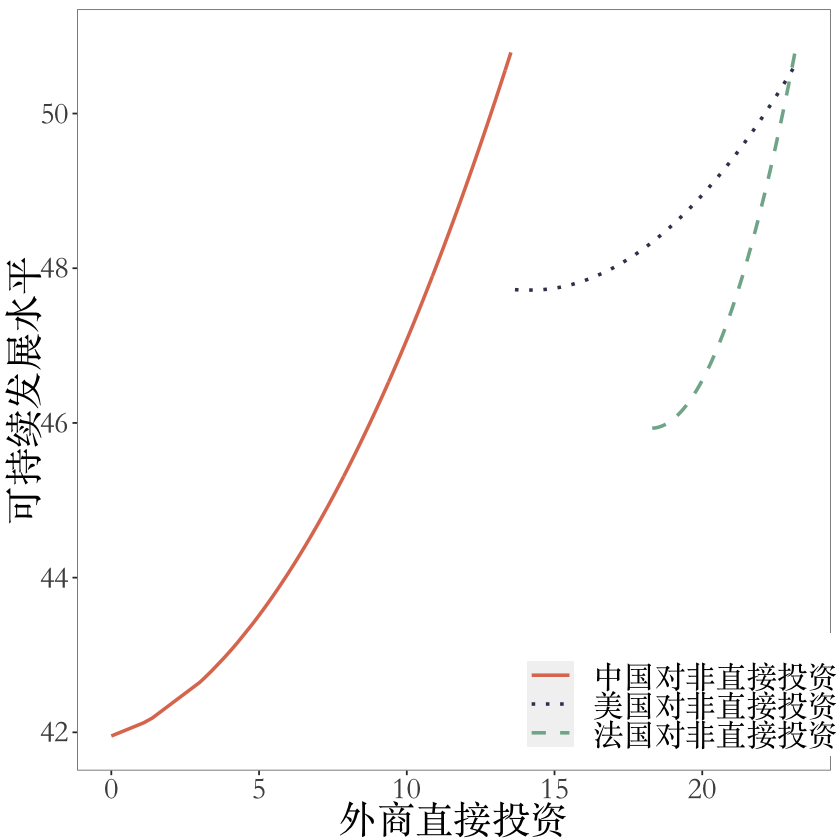

In [10]:
reg1 <- plm(SDI_100 ~ lnFDI_CN + I(lnFDI_CN^2) + economic + WGI + natural + urban + military,
    data = df_CN, model = "within", effect = "individual"
  )
reg2 <- plm(SDI_100 ~ lnFDI_US + I(lnFDI_US^2) + economic + WGI + natural + urban + military,
    data = df_US, model = "within", effect = "individual"
  )
reg3 <- plm(SDI_100 ~ lnFDI_FR + I(lnFDI_FR^2) + economic + WGI + natural + urban + military,
    data = df_FR, model = "within", effect = "individual"
  )

mydf <- ggpredict(reg1, terms = "lnFDI_CN [all]", interval="prediction")
mydf$group <- "中国对非直接投资"
mydf2 <- ggpredict(reg2, terms = "lnFDI_US [all]", interval="prediction")
mydf2$group <- "美国对非直接投资"
mydf3 <- ggpredict(reg3, terms = "lnFDI_FR [all]", interval="prediction")
mydf3$group <- "法国对非直接投资"

final_df0 <- mydf %>% rows_append(mydf2)
final_df <- final_df0 %>% rows_append(mydf3)

final_df$group <- factor(final_df$group, levels = c("中国对非直接投资", "美国对非直接投资", "法国对非直接投资"))
m1<-ggplot(final_df, aes(x = x, y = predicted, colour = group, linetype = group)) +
  theme(
    text = element_text(family='Songti SC',size = 23),
    panel.background = element_rect(fill = "white", colour = "grey50"),
    panel.grid = element_blank(),
    legend.position = c(0.8, 0.1),
    legend.key.width = unit(1,"cm"),
  ) +  
  geom_line(size=1) +
  scale_linetype_manual(values = c('solid','dotted', 'dashed')) +
  scale_color_manual(values = c(flatui[1],flatui[4], flatui[3])) + 
  labs(
    y = "可持续发展水平",
    x = "外商直接投资",
    colour = element_blank(),
    linetype = element_blank()
  )
#ggsave(file.path(Path.HOME, "OneDrive/PhD Dissertation/Pictures/不同来源地.png"), m1)
m1